In [2]:
import sys
sys.path.insert(0, '../')
import torch
import numpy as np
import cv2
import math
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms

from src import util
from src.model import handpose_model

/var/folders/3j/b323p0ws5zs_dnbwsxff73s80000gs/T/ipykernel_25098/1961878938.py:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [3]:
model = handpose_model()

model_dict = torch.load('../model/hand_pose_model.pth')

model.load_state_dict(util.transfer(model, model_dict))

test_image = '../images/hand.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order

scale_search = [0.5, 1.0, 1.5, 2.0]
# scale_search = [0.5]
boxsize = 368
stride = 8
padValue = 128
thre = 0.05
multiplier = [x * boxsize / oriImg.shape[0] for x in scale_search]
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 22))
# paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, stride, padValue)
    im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5
    im = np.ascontiguousarray(im)

    data = torch.from_numpy(im).float()
    if torch.cuda.is_available():
        data = data.cuda()
    # data = data.permute([2, 0, 1]).unsqueeze(0).float()
    with torch.no_grad():
        output = model(data).numpy()

    # extract outputs, resize, and remove padding
    heatmap = np.transpose(np.squeeze(output), (1, 2, 0))  # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

    heatmap_avg += heatmap / len(multiplier)

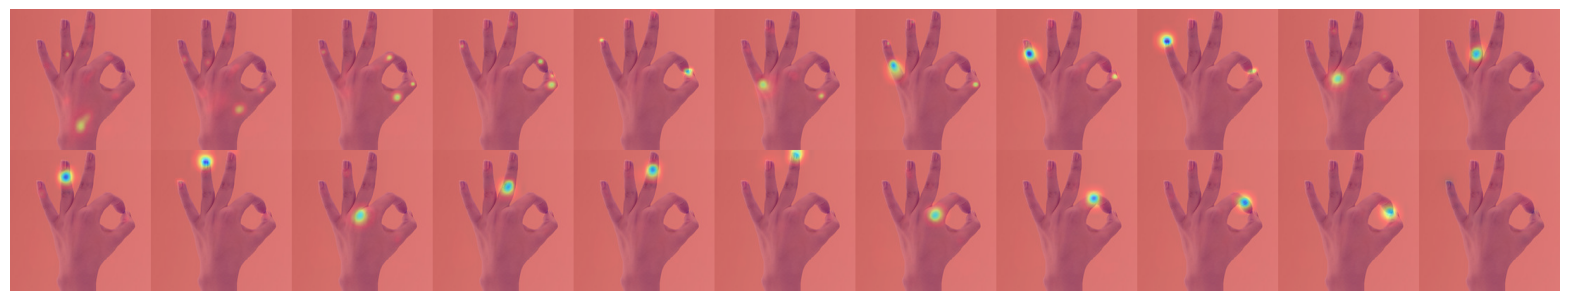

In [4]:
import torchvision
from PIL import Image
import matplotlib.cm as cm

def visualize(heatmap):
    plt.figure(figsize=(20,20))
    bg_list = torch.from_numpy(np.transpose(np.array([oriImg[:, :, [2, 1, 0]]]*22), (0, 3, 1, 2)))
    w = oriImg.shape[0]
    max_value = np.max(heatmap_avg)
    min_value = np.min(heatmap_avg)
    img_list = []
    im = Image.open(test_image)
    for i in range(22):
        vis_img = (heatmap[:, :, i]-min_value)/max_value
        vis_img = Image.fromarray(np.uint8(cm.jet(vis_img) * 255))
        vis_img = vis_img.convert('RGB') # dropping alpha channel
        vis_img = Image.blend(im, vis_img, 0.5)
        vis_img = np.array(vis_img)
        img_list.append(np.transpose(vis_img, (2, 0, 1)))
    img_list = torchvision.utils.make_grid(torch.from_numpy(np.array(img_list)), nrow=11, padding=0)
    plt.imshow(np.transpose(img_list.numpy(), (1, 2, 0))[...,::-1]) # bgr to rgb
    plt.axis('off')
visualize(heatmap_avg)

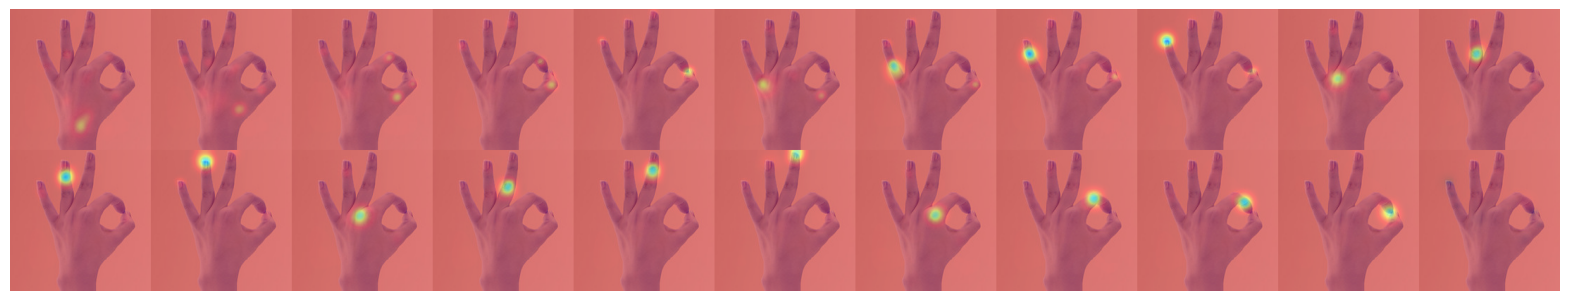

In [5]:
import copy
heatmap_1 = copy.deepcopy(heatmap_avg)
for part in range(21):
    map_ori = heatmap_1[:, :, part]
    one_heatmap = gaussian_filter(map_ori, sigma=3)
    heatmap_1[:, :, part] = one_heatmap
    
visualize(heatmap_1)

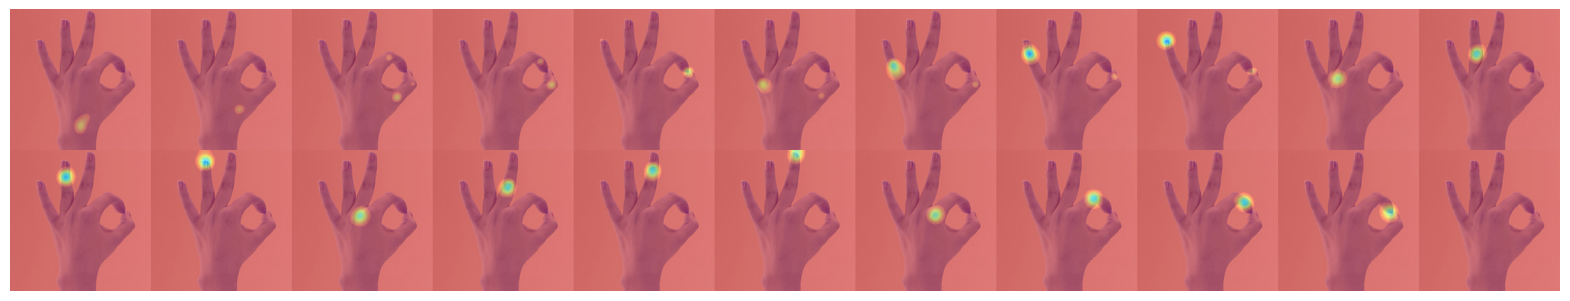

In [6]:
heatmap_2 = copy.deepcopy(heatmap_1)
heatmap_2[heatmap_2<thre] = 0
visualize(heatmap_2)

(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

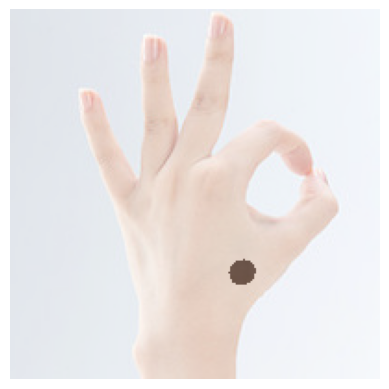

In [7]:
from skimage.measure import label

map_ori = heatmap_avg[:, :, 1]
one_heatmap = gaussian_filter(map_ori, sigma=3)
binary = np.ascontiguousarray(one_heatmap>0.05, dtype=np.uint8)
label_img, label_numbers = label(binary, return_num=True, connectivity = binary.ndim)
plt.imshow(oriImg[:, :, [2, 1, 0]])
plt.imshow(label_img, alpha=.5, cmap=plt.cm.hot_r)
plt.axis('off')

Text(125, 142, '1')

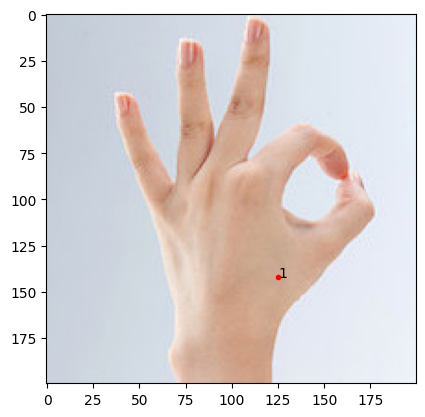

In [8]:
max_index = np.argmax([np.sum(map_ori[label_img == i]) for i in range(1, label_numbers+1)])+1
label_img[label_img!=max_index] = 0
map_ori[label_img==0] = 0
def npmax(array):
    arrayindex = array.argmax(1)
    arrayvalue = array.max(1)
    i = arrayvalue.argmax()
    j = arrayindex[i]
    return i, j
y, x = npmax(map_ori)

plt.imshow(oriImg[:, :, [2, 1, 0]])
plt.plot(x, y,'r.')
plt.text(x, y, '1')

In [9]:
all_peaks = []
for part in range(21):
    map_ori = heatmap_avg[:, :, part]
    one_heatmap = gaussian_filter(map_ori, sigma=3)
    binary = np.ascontiguousarray(one_heatmap>thre, dtype=np.uint8)
    # 全部小于阈值
    if np.sum(binary)==0:
        all_peaks.append(-1)
        continue
    label_img, label_numbers = label(binary, return_num=True, connectivity = binary.ndim)
    max_index = np.argmax([np.sum(map_ori[label_img == i]) for i in range(1, label_numbers+1)])+1
    label_img[label_img!=max_index] = 0
    map_ori[label_img==0] = 0
    def npmax(array):
        arrayindex = array.argmax(1)
        arrayvalue = array.max(1)
        i = arrayvalue.argmax()
        j = arrayindex[i]
        return i, j
    y, x = npmax(map_ori)
    all_peaks.append((x, y))

In [10]:
all_peaks

[(np.int64(100), np.int64(165)),
 (np.int64(125), np.int64(142)),
 (np.int64(149), np.int64(125)),
 (np.int64(168), np.int64(107)),
 (np.int64(162), np.int64(89)),
 (np.int64(68), np.int64(107)),
 (np.int64(54), np.int64(80)),
 (np.int64(46), np.int64(63)),
 (np.int64(42), np.int64(45)),
 (np.int64(84), np.int64(98)),
 (np.int64(81), np.int64(64)),
 (np.int64(79), np.int64(38)),
 (np.int64(78), np.int64(16)),
 (np.int64(97), np.int64(92)),
 (np.int64(107), np.int64(52)),
 (np.int64(112), np.int64(28)),
 (np.int64(116), np.int64(6)),
 (np.int64(113), np.int64(92)),
 (np.int64(138), np.int64(68)),
 (np.int64(152), np.int64(74)),
 (np.int64(159), np.int64(88))]

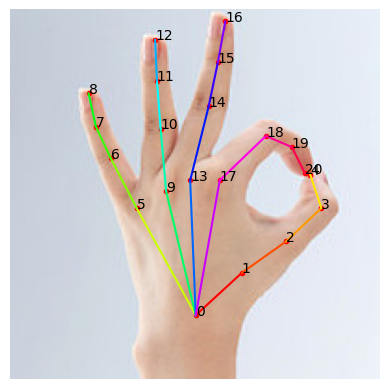

In [11]:
edges = [[0,1],[1,2],[2,3],[3,4],[0,5],[5,6],[6,7],[7,8],[0,9],[9,10], \
         [10,11],[11,12],[0,13],[13,14],[14,15],[15,16],[0,17],[17,18],[18,19],[19,20]]

plt.imshow(oriImg[:, :, [2, 1, 0]])

for i, (x, y) in enumerate(all_peaks):
    plt.plot(x, y,'r.')
    plt.text(x, y, str(i))
for ie, e in enumerate(edges):
    rgb = matplotlib.colors.hsv_to_rgb([ie/float(len(edges)), 1.0, 1.0])
    x1, y1 = all_peaks[e[0]]
    x2, y2 = all_peaks[e[1]]
    plt.plot([x1, x2], [y1, y2], color=rgb)
plt.axis('off')
plt.show()